In [1]:
!pip install tensorflow
print("done installing")

done installing


In [3]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

if not os.path.isdir('models'):
    os.mkdir('models')
    
print('Tensorflow version :',tf.__version__)

Tensorflow version : 2.2.0


## Preprocessing data

In [4]:
def get_three_classes(X, y):
    indices_0, _ = np.where(y == 0.)
    indices_1, _ = np.where(y == 1.)
    indices_2, _ = np.where(y == 2.)
    indices = np.concatenate([indices_0, indices_1, indices_2], axis=0)
    
    X = X[indices]
    y = y[indices]
    
    count = X.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    X = X[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return X, y

In [5]:
(X_tr, y_tr),(X_te,y_te) = tf.keras.datasets.cifar10.load_data()
X_tr,y_tr = get_three_classes(X_tr,y_tr)
X_te,y_te = get_three_classes(X_te,y_te)

print(X_tr.shape, y_tr.shape)
print(X_te.shape, y_te.shape)

170500096/170498071 [==============================] - 10s 0us/step
(15000, 32, 32, 3) (15000, 3)
(3000, 32, 32, 3) (3000, 3)


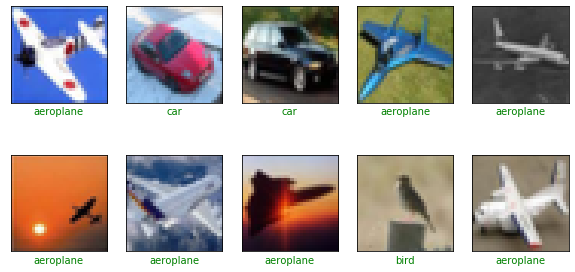

In [6]:
class_names = ['aeroplane','car','bird']

def show_random_samples(X,y,p):
    indices = np.random.choice(range(X.shape[0]),10,replace=False)
    
    X= X[indices]
    y = y[indices]
    p=p[indices]
    
    plt.figure(figsize=(10,5))
    for i in range(10):
        plt.subplot(2,5,1+i)
        plt.imshow(X[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names[np.argmax(p[i])], color =col)
    plt.show()

show_random_samples(X_tr,y_tr,y_tr)

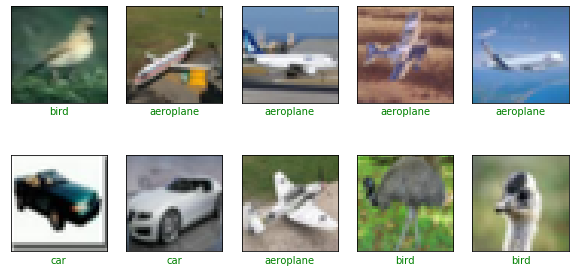

In [7]:
show_random_samples(X_te,y_te,y_te)


In [8]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

def create_model():
    def add_conv_block(model, num_filters):
        model.add(Conv2D(num_filters, 3, activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(num_filters, 3, activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(0.5))
        return model
    
    model = tf.keras.Sequential()
    model.add(Input(shape=(32, 32,3)))
    
    model = add_conv_block(model, 32)
    model = add_conv_block(model, 64)
    model = add_conv_block(model, 128)
    
    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',metrics=['accuracy']
    )
    
    return model
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 64)        2

## Train Model

In [14]:
h= model.fit(
    X_tr/255.,y_tr,
    validation_data=(X_te/255. , y_te),
    epochs=10, batch_size=128,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
              tf.keras.callbacks.ModelCheckpoint('models/model_{val_accuracy:.3f}.h5',
                                                save_best_only=True,save_weights_only=False,monitor='val_accuracy')
              ]
)

Epoch 1/10
118/118 [==============================] - 37s 310ms/step - loss: 0.2819 - accuracy: 0.8895 - val_loss: 0.4612 - val_accuracy: 0.8303
Epoch 2/10
118/118 [==============================] - 36s 302ms/step - loss: 0.2727 - accuracy: 0.8932 - val_loss: 0.2509 - val_accuracy: 0.8960
Epoch 3/10
118/118 [==============================] - 36s 307ms/step - loss: 0.2553 - accuracy: 0.9024 - val_loss: 0.4758 - val_accuracy: 0.8327
Epoch 4/10
118/118 [==============================] - 38s 321ms/step - loss: 0.2504 - accuracy: 0.9025 - val_loss: 0.2574 - val_accuracy: 0.8913
Epoch 5/10
118/118 [==============================] - 40s 336ms/step - loss: 0.2425 - accuracy: 0.9078 - val_loss: 0.2605 - val_accuracy: 0.8997
Epoch 6/10
118/118 [==============================] - 42s 353ms/step - loss: 0.2351 - accuracy: 0.9074 - val_loss: 0.3849 - val_accuracy: 0.8633
Epoch 7/10
118/118 [==============================] - 41s 351ms/step - loss: 0.2256 - accuracy: 0.9147 - val_loss: 0.2358 - val_ac

## Final Prediction

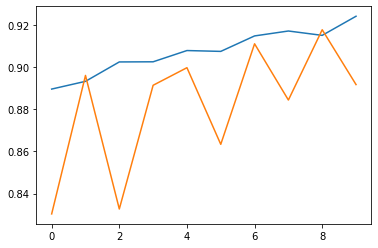

In [15]:
accs = h.history['accuracy']
val_accs = h.history['val_accuracy']

plt.plot(range(10), accs,label='Training')
plt.plot(range(10), val_accs, label='Validation')

In [16]:
model = tf.keras.models.load_model('models/model_0.918.h5')

In [19]:
preds = model.predict(X_te/255.)

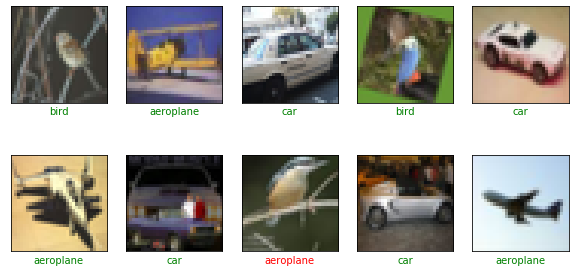

In [20]:
show_random_samples(X_te,y_te,preds)